In [1]:
import os
os.chdir("../..")
import process_experimental_data as prepos
from set_parameters import (
    set_thermal_parameters,
    set_experiment_parameters,
    set_ambient_temperature,
)
import pybamm
import numpy as np
import pbparam
import pandas as pd


In [2]:
temperature = 25  # in degC, valid values: 0, 10, 25
crate = 1  # valid values: 0.5, 1, 2
cell_selected = ["789"]

In [3]:
dataset = prepos.import_thermal_data(crate, temperature)
data_conc = {
    "Time [s]": [],
    "Terminal voltage [V]": [],
    "X-averaged cell temperature [degC]": [],
}
for cell, data in dataset.items():
    if cell in cell_selected:
        idx_start, idx_end = prepos.get_idxs(data, crate * 5, 5 / 3)
        if len(idx_end) == 1:
            idx_end = np.append(idx_end, len(data["Time [s]"]))
        data_conc["Time [s]"] = np.append(
            data_conc["Time [s]"],
            data["Time [s]"][idx_start[0] : idx_end[1]]
            - data["Time [s]"][idx_start[0]],
        )
        data_conc["Terminal voltage [V]"] = np.append(
            data_conc["Terminal voltage [V]"],
            data["Voltage [V]"][idx_start[0] : idx_end[1]],
        )
        data_conc["X-averaged cell temperature [degC]"] = np.append(
            data_conc["X-averaged cell temperature [degC]"],
            data["Temp Cell [degC]"][idx_start[0] : idx_end[1]],
        )
data_conc = pd.DataFrame(data_conc)
data_conc["X-averaged cell temperature [degC]"] = (
    data_conc["X-averaged cell temperature [degC]"] + 273.15
)
data_conc = data_conc.rename(
    columns={"X-averaged cell temperature [degC]": "X-averaged cell temperature [K]"}
)

In [4]:
def j0_neg(c_e, c_s_surf, c_s_max, T):
    """
    This function has been copied from the Chen2020 parameter set:
    pybamm/input/parameters/lithium_ion/negative_electrodes/graphite_Chen2020
    /graphite_LGM50_electrolyte_exchange_current_density_Chen2020.py
    Similar could be done for the positive exchange current density
    """
    m_ref = pybamm.Parameter("Negative electrode reaction coefficient")
    E_r = 3500
    arrhenius = pybamm.exp(E_r / pybamm.constants.R * (1 / 298.15 - 1 / T))
    return (
        m_ref * arrhenius * c_e**0.5 * c_s_surf**0.5 * (c_s_max - c_s_surf) ** 0.5
    )

In [5]:
model = pybamm.lithium_ion.SPMe(
    options={
        "thermal": "lumped",
        "dimensionality": 0,
        "cell geometry": "arbitrary",
        "electrolyte conductivity": "integrated",
    },
    name="TSPMe",
)

In [6]:
param_default = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Chen2020)
param = set_thermal_parameters(param_default, 16, 2.32e6, temperature)
param = set_experiment_parameters(param, crate, temperature)
param = set_ambient_temperature(param, crate, temperature)
param.update(
    {
        # "Negative electrode exchange-current density [A.m-2]": j0_neg,
        "Negative electrode reaction coefficient": 6.48e-7
    },
    check_already_exists=False,
)
experiment = pybamm.Experiment(
    [
        "Discharge at {}C until 2.5 V (5 seconds period)".format(crate),
        "Rest for 2 hours",
    ],
    period="30 seconds",
)
simulation = pybamm.Simulation(
    model,
    parameter_values=param,
    experiment=experiment,
)
param_optimised = {
    "Negative electrode diffusivity [m2.s-1]": (5e-14, (2.06e-16, 2.06e-12)),
    "Negative electrode reaction coefficient": (
        6.48e-7,
        (2.18589831e-9, 2.18589831e-5),
    ),
    "Total heat transfer coefficient [W.m-2.K-1]": (20, (0.1, 1000)),
    (
        "Positive current collector specific heat capacity [J.kg-1.K-1]",
        "Negative current collector specific heat capacity [J.kg-1.K-1]",
        "Negative electrode specific heat capacity [J.kg-1.K-1]",
        "Separator specific heat capacity [J.kg-1.K-1]",
        "Positive electrode specific heat capacity [J.kg-1.K-1]",
    ): (2.85e3, (2.85, 2.85e6)),
}

In [7]:
variables_optimised = ["Terminal voltage [V]", "X-averaged cell temperature [K]"]
cost_function = pbparam.RMSE()
opt = pbparam.DataFit(cost_function, simulation, data_conc, param_optimised, variables_optimised)

In [8]:
# optimiser = pbparam.ScipyDifferentialEvolution(
#     extra_options={"workers": 4, "polish": True, "updating": "deferred", "disp": True}
# )
optimiser = pbparam.ScipyMinimize(method="Nelder-Mead", extra_options={"tol": 1e-6})

In [9]:
result = optimiser.optimise(opt)

[1. 1. 1. 1.]
[(0.0041199999999999995, 41.2), (0.0033732998611111114, 33.732998611111114), (0.005, 50.0), (0.001, 1000.0)]
0.15686316170730222
1.4761037186060761
0.16161007781931142
1.4788562652178352
0.15686316170730222
1.4761037186060761
0.15657002774195786
1.3573870239556245
0.15671004913325695
1.5144046015006363
0.151516673015543
1.4318955786359537
0.1458659197270408
1.4102613667543102
0.15157106822084154
1.3422517103547722
0.14863621355523565
1.3218330517250845
0.1441731200052488
1.2550508540740344
0.13697731567499066
1.1673501598051823
0.13349283281341479
1.2542166282219513
0.11876833860306318
1.2060594188500944
0.12263473467978196
1.2197321507031247
0.1106752585229615
1.182642680641015
0.08416722809247444
1.1301349256952626
0.07756723270434365
1.0207151491911945
0.05014607341404974
0.9244043165075501
0.04986440153741745
1.019458811105762
0.11959443734612815
0.90732443173719
0.8491046616164063
3.327594294640214
0.08182153639306688
1.0767668532337293
0.10636968865122387
1.15814294

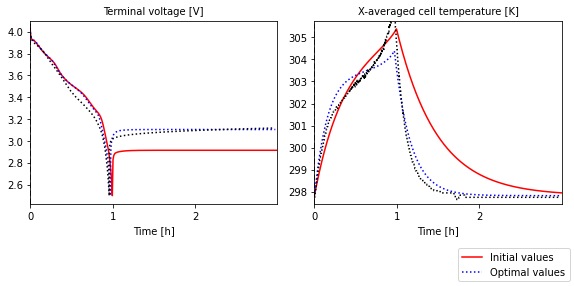

In [10]:
result.plot()